# Regression via LSTM

Here, we test approach to learn known solution to the ODE in some points by training the neural network. 

Thus, the approximation for each X(t), Y(t), Z(t) is builded.

Then, neural network can be easily differentiated and we can compute all the derivatives.

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm

In [2]:
t, xs, ys, zs = np.load('data.npy')

In [3]:
sp = 10 # sparse parameter for data that are to be trained
x_train, y_train = t[::sp], [xs[::sp], ys[::sp], zs[::sp]]
x_test, y_test = t, [xs, ys, zs]

In [4]:
Diff = L.Lambda(lambda x: tf.gradients(x[0], x[1])[0])
Tanh = L.Lambda(lambda x: tf.math.tanh(x))
iDense = L.Lambda(lambda x: (1.0 - x[0]) * x[1] + x[0] * x[2], name='iDense') # [Z, U, V]

class AdaptTanh(L.Layer):
    def __init__(self, n, **kwargs):
        super(AdaptTanh, self).__init__(**kwargs)
        self.n = n
        self.a = self.add_weight(name='a', 
                                 shape=(1,),
                                 initializer='ones',
                                 trainable=True) 
    def call(self, X):
        return tf.math.tanh(self.n * self.a * X)

In [19]:
def NNmodel(nl=3, nu=100, inshape=(1,), outdim=3, UV=False, Layer=L.LSTM,
            adaptAct=1, resnet=False, ni=10):
    t = L.Input(inshape, name='t')
    
    N = nl + UV * 2
    if adaptAct == 0:
        acts = ['tanh']*N
    elif adaptAct == 1:
        acts = [AdaptTanh(ni)]*N
    else:
        acts = [AdaptTanh(ni) for _ in range(N)]
    
    if UV:
        U = Layer(nu, activation=acts[-1])(t)
        V = Layer(nu, activation=acts[-2])(t)
    
    outs = []
    x = Layer(nu, activation=acts[0])(t)
    for i in range(nl - 1):
        y = Layer(nu, activation=acts[i+1])(x)
        if UV:
            y = iDense([y, U, V])
        elif resnet:
            y = L.Add()([y, x])
        else: pass
        x = y
    Y = L.Dense(outdim, activation='linear')(x)
    Ym = Model(inputs=t, outputs=Y)
    
    dY = Diff([Y, t])
    dYm = Model(inputs=t, outputs=dY)
    
    return Ym, dYm

In [20]:
Y, dY = NNmodel(nl=1, nu=100, inshape=(1,1), outdim=3, UV=False, adaptAct=0)

In [21]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-4)
Y.compile(optimizer=adam, loss='mse')

In [22]:
h = Y.fit(x=x_train, y=y_train, 
            epochs=1000, 
            verbose=1, 
            batch_size=128,)

Epoch 1/1000
79/79 [==============================] - 0s 3ms/step - loss: 62.7682
Epoch 2/1000
79/79 [==============================] - 0s 3ms/step - loss: 60.3226
Epoch 3/1000
79/79 [==============================] - 0s 3ms/step - loss: 58.1683
Epoch 4/1000
79/79 [==============================] - 0s 3ms/step - loss: 56.8821
Epoch 5/1000
79/79 [==============================] - 0s 3ms/step - loss: 56.2318
Epoch 6/1000
79/79 [==============================] - 0s 3ms/step - loss: 55.9439
Epoch 7/1000
79/79 [==============================] - 0s 4ms/step - loss: 55.8124
Epoch 8/1000
79/79 [==============================] - 0s 5ms/step - loss: 55.7094
Epoch 9/1000
79/79 [==============================] - 0s 5ms/step - loss: 55.6468
Epoch 10/1000
79/79 [==============================] - 0s 4ms/step - loss: 55.6041
Epoch 11/1000
79/79 [==============================] - 0s 4ms/step - loss: 55.5899
Epoch 12/1000
79/79 [==============================] - 0s 4ms/step - loss: 55.5598
Epoch 13/1000

KeyboardInterrupt: 

In [23]:
y_pred = Y.predict(x_test)

In [27]:
np.save('y_pred.npy', y_pred.T)

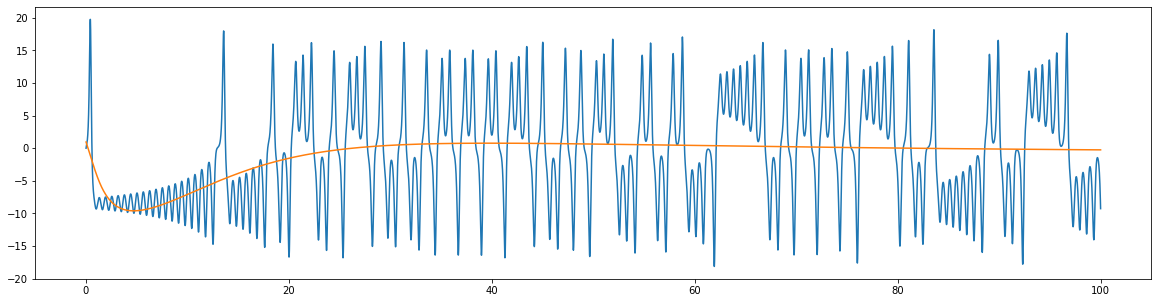

In [25]:
plt.figure(figsize=(20,5))
plt.plot(x_train, y_train[0])
plt.plot(x_test, y_pred[:,0])